<a href="https://colab.research.google.com/github/Jainish5658/Physics-Informed-Nueral-Networks/blob/main/underdamped_harmonic_osciallator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.2/184.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.7 MB/s eta 0:00:00


Compiling model...
Building feed-forward neural network...
'build' took 0.065173 s

'compile' took 0.668166 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.08e+02, 1.60e+01, 1.69e+01]    [1.09e+02, 1.60e+01, 1.69e+01]    []  
1000      [5.74e-01, 9.30e-02, 1.27e+01]    [5.18e-01, 9.30e-02, 1.27e+01]    []  
2000      [3.09e+00, 2.91e-03, 2.10e+00]    [2.29e+00, 2.91e-03, 2.10e+00]    []  
3000      [2.95e+00, 3.04e-04, 1.48e+00]    [3.03e+00, 3.04e-04, 1.48e+00]    []  
4000      [2.89e+00, 2.05e-04, 1.48e+00]    [3.13e+00, 2.05e-04, 1.48e+00]    []  
5000      [2.83e+00, 2.95e-05, 1.48e+00]    [3.09e+00, 2.95e-05, 1.48e+00]    []  
6000      [2.83e+00, 5.26e-06, 1.41e+00]    [2.95e+00, 5.26e-06, 1.41e+00]    []  
7000      [2.80e+00, 1.37e-05, 1.41e+00]    [3.03e+00, 1.37e-05, 1.41e+00]    []  
8000      [2.79e+00, 1.56e-05, 1.41e+00]    [3.00e+00, 1.56e-05, 1.41e+00]    []  
9000      [2.79e+00, 8.23e-08, 1.

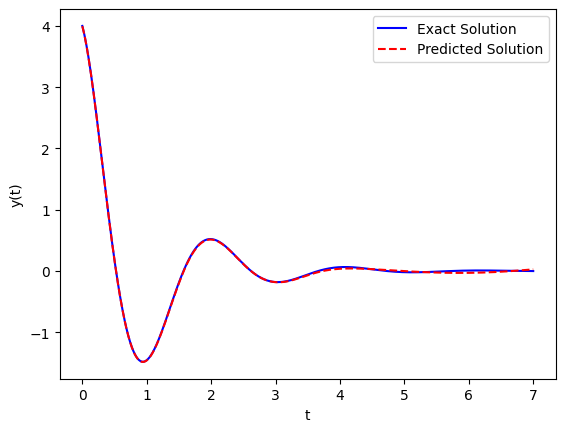

In [ ]:
# Import necessary libraries
import numpy as np
import deepxde as dde
from deepxde.backend import tf
import matplotlib.pyplot as plt

# Define the ODE residual function
def ode_system(x, y):
    """
    The ODE residual function for y'' + 2 y' + 10 y = 0
    """
    dy = dde.grad.jacobian(y, x)  # First derivative y'
    ddy = dde.grad.hessian(y, x)  # Second derivative y''
    return ddy + 2 * dy + 10 * y  # The residual of the ODE

# Define the time domain geometry
geom = dde.geometry.TimeDomain(0, 10)  # Time domain from t=0 to t=10

# Define the initial condition y(0) = 4
ic1 = dde.IC(
    geom,  # Geometry
    lambda x: 4,  # Initial condition function y(0) = 4
    lambda _, on_initial: on_initial  # Apply at t=0
)

# Define the initial derivative condition y'(0) = -4
ic2 = dde.OperatorBC(
    geom,  # Geometry
    lambda x, y, _: dde.grad.jacobian(y, x) + 4,  # Residual dy/dt + 4 = 0
    lambda x, on_initial: on_initial  # Apply at t=0
)

# Combine the boundary conditions
bcs = [ic1, ic2]

# Create the data object for the PDE problem
data = dde.data.PDE(
    geom,  # Geometry
    ode_system,  # ODE residual function
    bcs,  # Boundary conditions (initial conditions)
    num_domain=300,  # Number of training points inside the domain
    num_boundary=5,  # Number of training points on the boundary (t=0 and t=10)
    num_test=100  # Number of test points
)

# Define the neural network model
net = dde.maps.FNN(
    [1] + [50] * 3 + [1],  # Number of neurons in each layer
    "tanh",  # Activation function
    "Glorot uniform"  # Weight initializer
)

# Create the model by combining data and network
model = dde.Model(data, net)

# Compile the model with an optimizer and learning rate
model.compile("adam", lr=0.001)

# Train the model
losshistory, train_state = model.train(epochs=10000)

# Switch to L-BFGS optimizer for better convergence
model.compile("L-BFGS")
losshistory, train_state = model.train()

# Generate test data for plotting
t = np.linspace(0, 7, 1000)[:, None]  # Shape (N, 1)

# Predict y(t) using the trained model
y_pred = model.predict(t)

# Compute the exact solution for comparison
y_exact = 4 * np.exp(-t) * np.cos(3 * t)

# Plot the predicted solution and the exact solution
plt.figure()
plt.plot(t, y_exact, 'b-', label='Exact Solution')
plt.plot(t, y_pred, 'r--', label='Predicted Solution')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
plt.show()
